# Telecom Churn Prediction - Starter Notebook

**Authors:** Surya Chandra & Joseph Mattamana

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading Dependencies & Datasets

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load the given datasets and the data dictionary files.

As per the given data, The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, we will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
#Reding the Data

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [4]:
# Display the first few rows of the dataframe
data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [5]:
# Get the summary of the dataframe
print(data.info(verbose=1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [6]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 id                     0
circle_id              0
loc_og_t2o_mou       702
std_og_t2o_mou       702
loc_ic_t2o_mou       702
                    ... 
aon                    0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 172, dtype: int64


In [7]:
# Check for duplicates
duplicates = data.duplicated().sum()
print("Number of duplicate rows: ", duplicates)

Number of duplicate rows:  0


In [8]:
# Check the unique values for each column
for col in data.columns:
    print(f'{col}: {data[col].nunique()} unique values')

id: 69999 unique values
circle_id: 1 unique values
loc_og_t2o_mou: 1 unique values
std_og_t2o_mou: 1 unique values
loc_ic_t2o_mou: 1 unique values
last_date_of_month_6: 1 unique values
last_date_of_month_7: 1 unique values
last_date_of_month_8: 1 unique values
arpu_6: 61615 unique values
arpu_7: 61425 unique values
arpu_8: 60194 unique values
onnet_mou_6: 20057 unique values
onnet_mou_7: 20076 unique values
onnet_mou_8: 19725 unique values
offnet_mou_6: 26254 unique values
offnet_mou_7: 26139 unique values
offnet_mou_8: 25995 unique values
roam_ic_mou_6: 5306 unique values
roam_ic_mou_7: 4240 unique values
roam_ic_mou_8: 4252 unique values
roam_og_mou_6: 6568 unique values
roam_og_mou_7: 5305 unique values
roam_og_mou_8: 5215 unique values
loc_og_t2t_mou_6: 11491 unique values
loc_og_t2t_mou_7: 11359 unique values
loc_og_t2t_mou_8: 11296 unique values
loc_og_t2m_mou_6: 17848 unique values
loc_og_t2m_mou_7: 17641 unique values
loc_og_t2m_mou_8: 17616 unique values
loc_og_t2f_mou_6: 3376

In [9]:
# Identify columns to drop
# cols_to_drop = [col for col in data.columns if data[col].nunique() <= 1]
# cols_to_drop

In [10]:
# data.info(verbose=1)

In [11]:
# data.drop(cols_to_drop, axis=1, inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [13]:
data.describe(include="all")

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   69999.000000    69999.0         69297.0         69297.0   
unique           NaN        NaN             NaN             NaN   
top              NaN        NaN             NaN             NaN   
freq             NaN        NaN             NaN             NaN   
mean    34999.000000      109.0             0.0             0.0   
std     20207.115084        0.0             0.0             0.0   
min         0.000000      109.0             0.0             0.0   
25%     17499.500000      109.0             0.0             0.0   
50%     34999.000000      109.0             0.0             0.0   
75%     52498.500000      109.0             0.0             0.0   
max     69998.000000      109.0             0.0             0.0   

        loc_ic_t2o_mou last_date_of_month_6 last_date_of_month_7  \
count          69297.0                69999                69600   
unique             NaN                    1                    1   
top                NaN            6/30/2014            7/31/2014   
freq               NaN                69999                69600   
mean               0.0                  NaN                  NaN   
std                0.0                  NaN                  NaN   
min                0.0                  NaN                  NaN   
25%                0.0                  NaN                  NaN   
50%                0.0                  NaN                  NaN   
75%                0.0                  NaN                  NaN   
max                0.0                  NaN                  NaN   

       last_date_of_month_8        arpu_6        arpu_7  ...   sachet_3g_7  \
count                 69266  69999.000000  69999.000000  ...  69999.000000   
unique                    1           NaN           NaN  ...           NaN   
top               8/31/2014           NaN           NaN  ...           NaN   
freq                  69266           NaN           NaN  ...           NaN   
mean                    NaN    283.134365    278.185912  ...      0.081444   
std                     NaN    334.213918    344.366927  ...      0.634547   
min                     NaN  -2258.709000  -1289.715000  ...      0.000000   
25%                     NaN     93.581000     86.714000  ...      0.000000   
50%                     NaN    197.484000    191.588000  ...      0.000000   
75%                     NaN    370.791000    365.369500  ...      0.000000   
max                     NaN  27731.088000  35145.834000  ...     33.000000   

         sachet_3g_8     fb_user_6     fb_user_7     fb_user_8           aon  \
count   69999.000000  17568.000000  17865.000000  18417.000000  69999.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        0.085487      0.916325      0.909544      0.890319   1220.639709   
std         0.680035      0.276907      0.286842      0.312501    952.426321   
min         0.000000      0.000000      0.000000      0.000000    180.000000   
25%         0.000000      1.000000      1.000000      1.000000    468.000000   
50%         0.000000      1.000000      1.000000      1.000000    868.000000   
75%         0.000000      1.000000      1.000000      1.000000   1813.000000   
max        41.000000      1.000000      1.000000      1.000000   4337.000000   

          aug_vbc_3g    jul_vbc_3g   jun_vbc_3g  churn_probability  
count   69999.000000  69999.000000  69999.00000       69999.000000  
unique           NaN           NaN          NaN                NaN  
top              NaN           NaN          NaN                NaN  
freq             NaN           NaN          NaN                NaN  
mean       68.108597     65.935830     60.07674           0.101887  
std       269.328659    267.899034    257.22681           0.302502  
min         0.0

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [14]:
data['circle_id'].unique()

array([109])

In [15]:
X = data.drop(['circle_id'],1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 170), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 170), (14000, 170), (55999,), (14000,))

In [17]:
X_train.head()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
3608    3608             0.0             0.0             0.0   
62867  62867             0.0             0.0             0.0   
21762  21762             0.0             0.0             0.0   
32064  32064             0.0             0.0             0.0   
34427  34427             0.0             0.0             0.0   

      last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
3608             6/30/2014            7/31/2014            8/31/2014    9.408   
62867            6/30/2014            7/31/2014            8/31/2014   86.651   
21762            6/30/2014            7/31/2014            8/31/2014  237.276   
32064            6/30/2014            7/31/2014            8/31/2014  462.877   
34427            6/30/2014            7/31/2014            8/31/2014   44.140   

         arpu_7   arpu_8  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  \
3608    142.491   42.340  ...            0            0            0   
62867    41.037    1.400  ...            0            0            0   
21762   210.904  207.653  ...            0            0            0   
32064  1377.699  178.351  ...            0            0            0   
34427    18.084   87.793  ...            0            0            0   

       fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  \
3608         NaN        NaN        NaN  1112         0.0         0.0   
62867        NaN        NaN        NaN   280         0.0         0.0   
21762        NaN        NaN        NaN  2579         0.0         0.0   
32064        1.0        1.0        1.0   480         0.0         0.0   
34427        1.0        NaN        0.0   823         0.0         0.0   

       jun_vbc_3g  
3608         0.35  
62867        0.00  
21762        0.00  
32064        0.00  
34427        0.00  

[5 rows x 170 columns]

# 3. Handling Missing data

<Axes: >

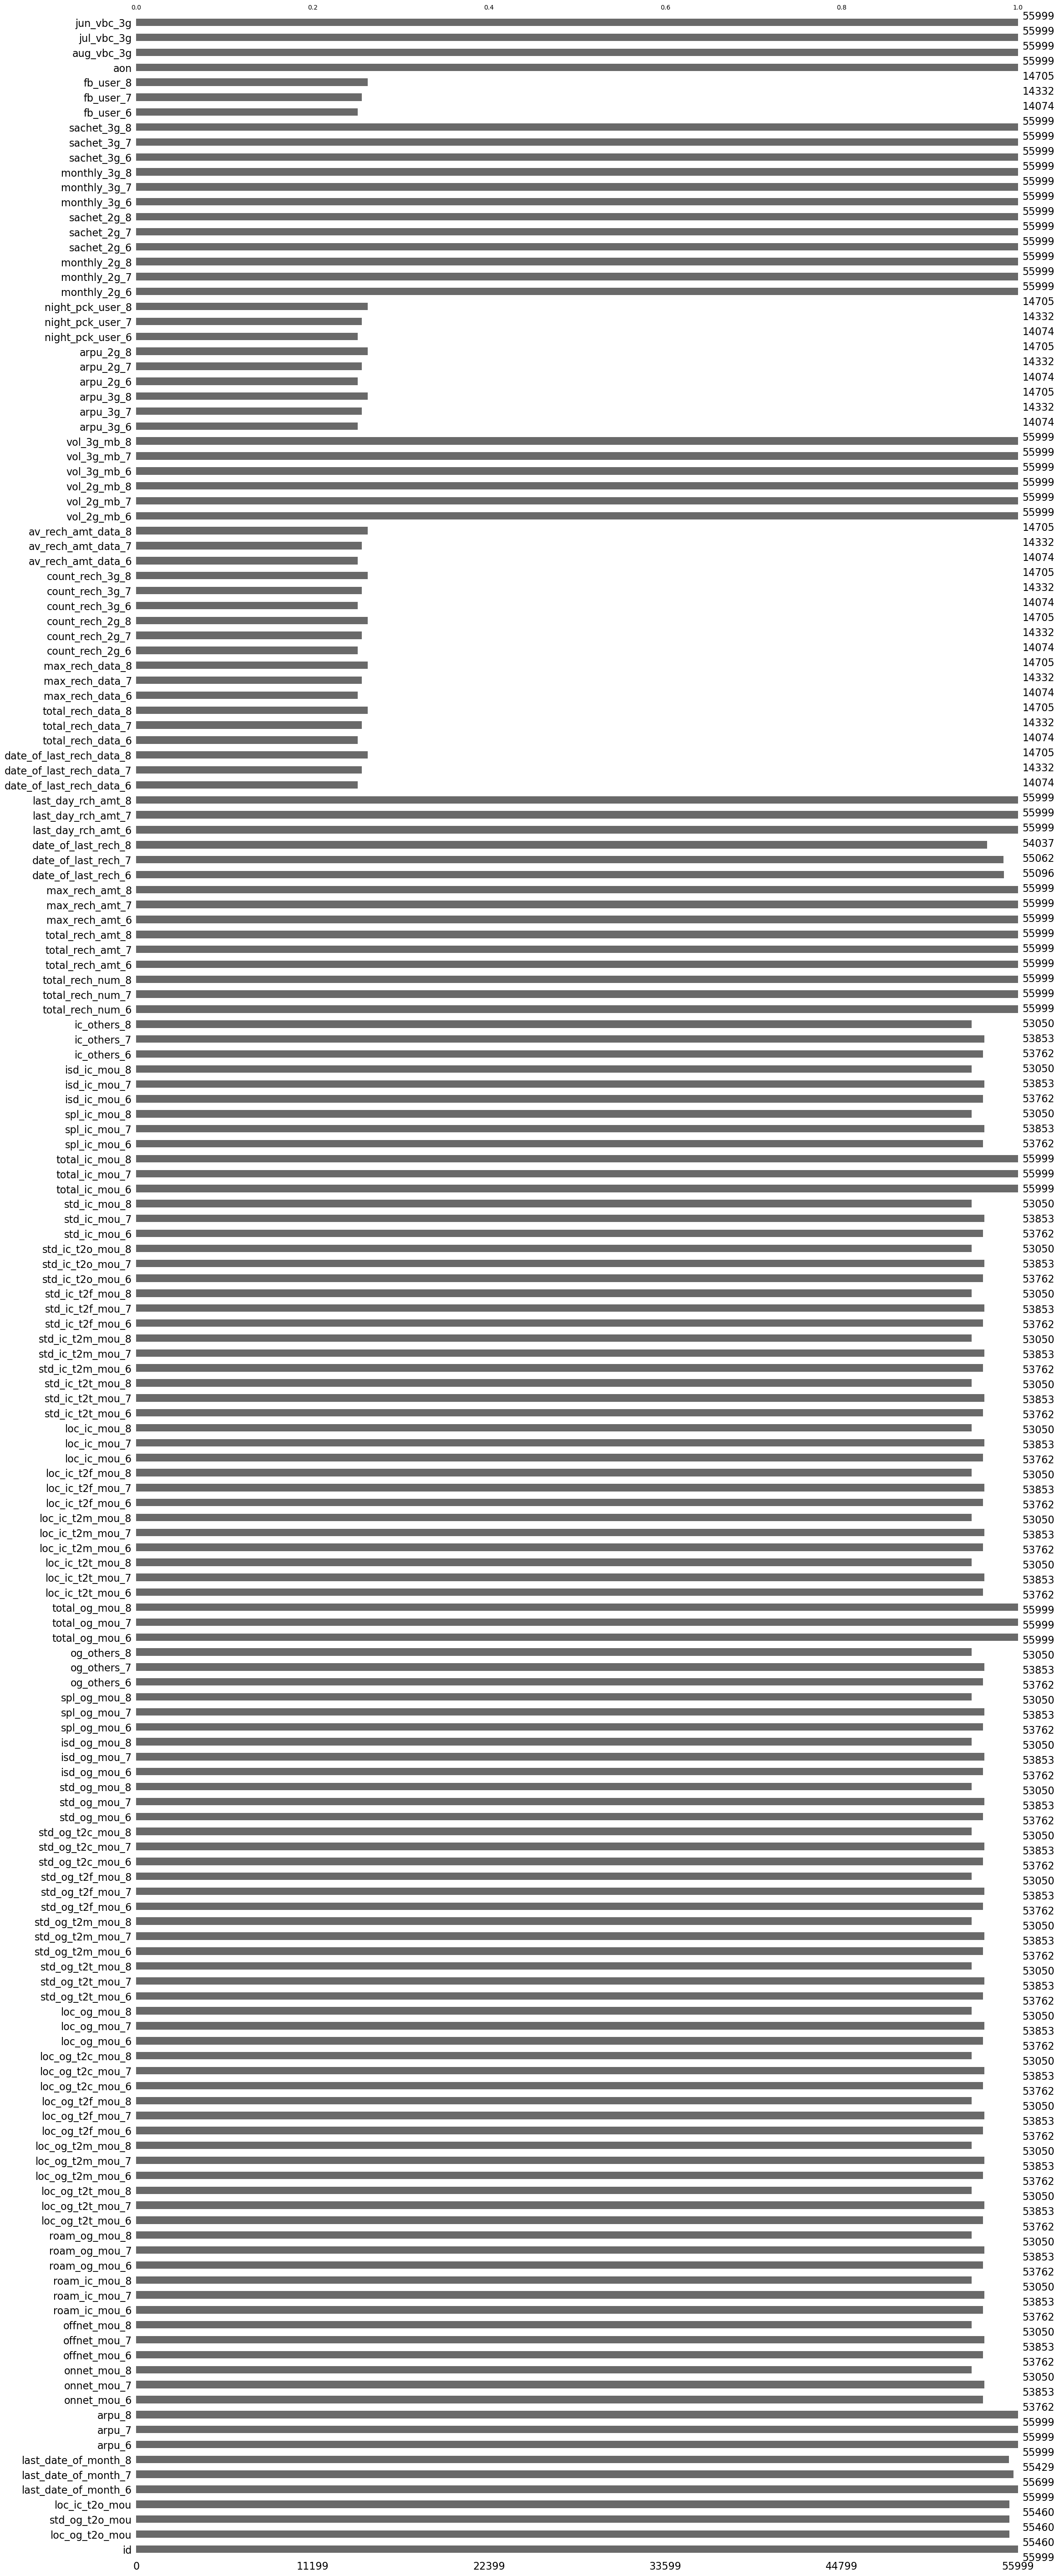

In [18]:
msno.bar(X_train)

<Axes: >

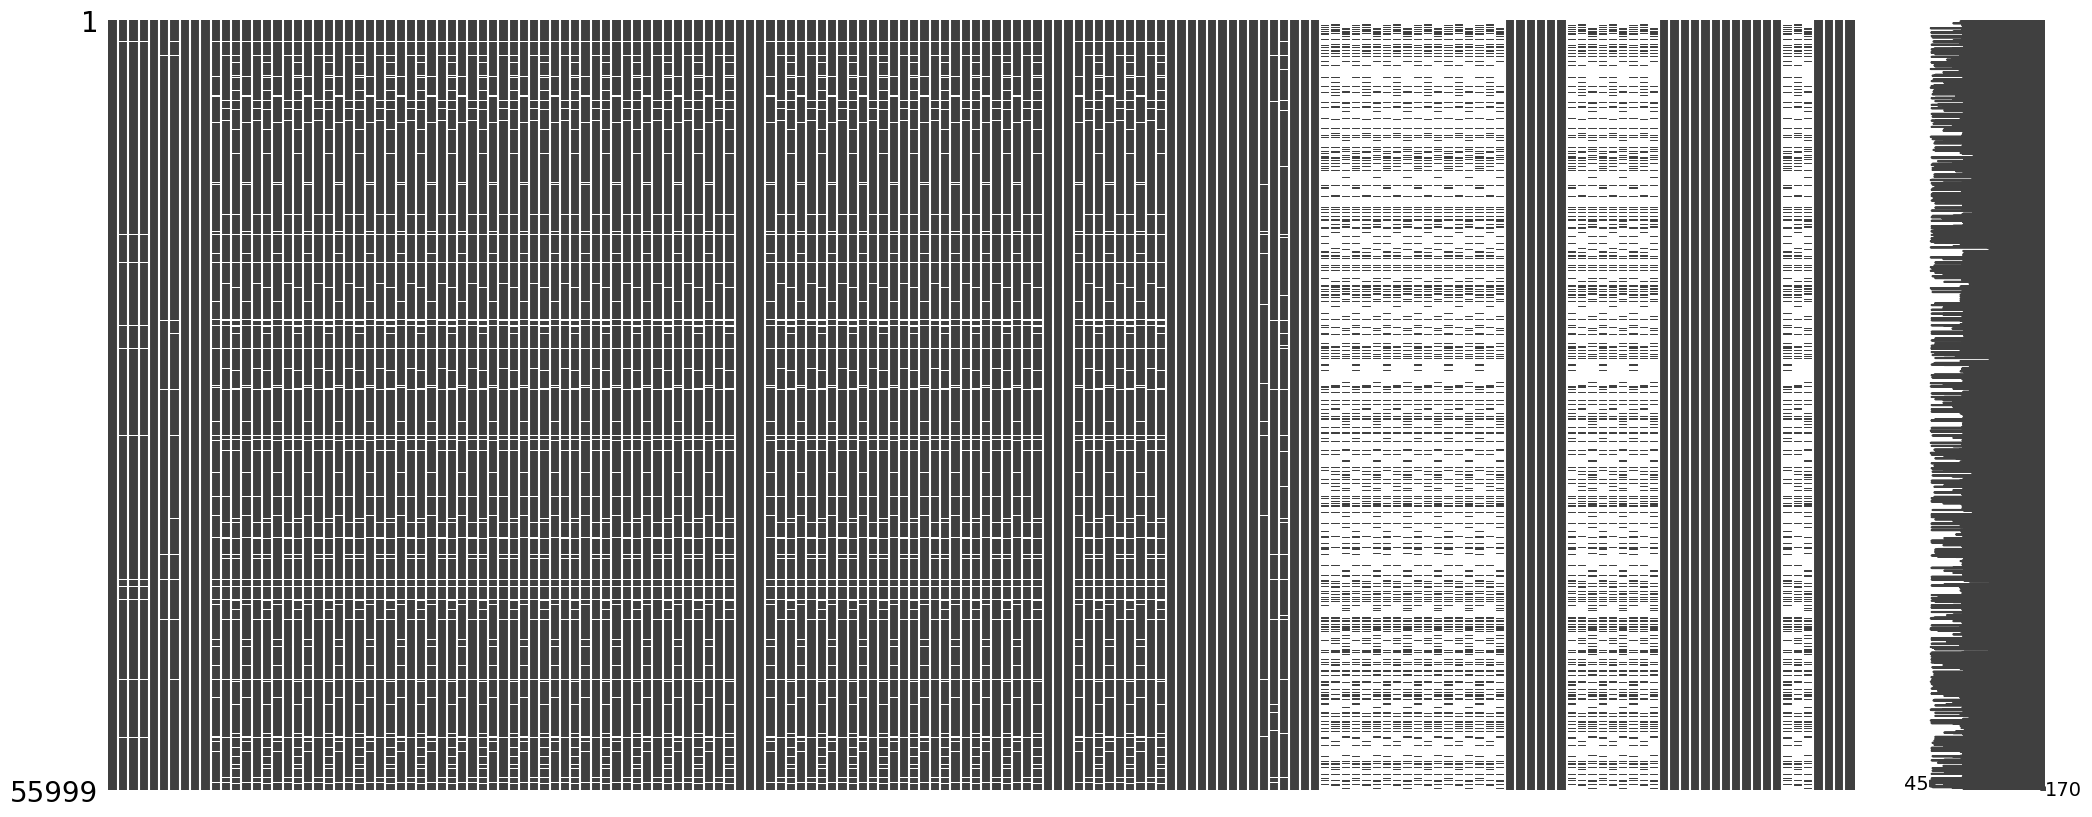

In [19]:
msno.matrix(X_train)

In [20]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

id                       0.000000
loc_og_t2o_mou           0.962517
std_og_t2o_mou           0.962517
loc_ic_t2o_mou           0.962517
last_date_of_month_6     0.000000
                          ...    
fb_user_8               73.740603
aon                      0.000000
aug_vbc_3g               0.000000
jul_vbc_3g               0.000000
jun_vbc_3g               0.000000
Length: 170, dtype: float64

In [21]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
print(new_vars)

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=140)


In [22]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 140)

In [23]:
X_train_filtered.describe()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count  55999.000000         55460.0         55460.0         55460.0   
mean   35046.215290             0.0             0.0             0.0   
std    20204.989439             0.0             0.0             0.0   
min        0.000000             0.0             0.0             0.0   
25%    17540.500000             0.0             0.0             0.0   
50%    35092.000000             0.0             0.0             0.0   
75%    52562.000000             0.0             0.0             0.0   
max    69997.000000             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  55999.000000  55999.000000  55999.000000  53762.000000  53853.000000   
mean     282.920597    278.555044    278.904174    133.057341    133.533468   
std      339.882961    352.939330    351.091001    301.246885    310.070662   
min    -2041.228000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.534000     86.816000     84.966500      7.430000      6.710000   
50%      197.241000    192.408000    192.209000     34.210000     32.410000   
75%      370.132000    365.145500    369.577500    118.960000    115.860000   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  ...  monthly_3g_6  monthly_3g_7  monthly_3g_8  \
count  53050.000000  ...  55999.000000  55999.000000  55999.000000   
mean     132.895243  ...      0.075394      0.078644      0.082359   
std      307.768617  ...      0.358268      0.387758      0.383789   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.415000  ...      0.000000      0.000000      0.000000   
50%       32.260000  ...      0.000000      0.000000      0.000000   
75%      115.525000  ...      0.000000      0.000000      0.000000   
max     8022.980000  ...      9.000000     16.000000     16.000000   

        sachet_3g_6   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean       0.073608      0.078144      0.083180   1222.525581     68.960181   
std        0.554031      0.601022      0.661754    954.550540    268.884652   
min        0.000000      0.000000      0.000000    180.000000      0.000000   
25%        0.000000      0.000000      0.000000    468.000000      0.000000   
50%        0.000000      0.000000      0.000000    869.000000      0.000000   
75%        0.000000      0.000000      0.000000   1815.500000      0.000000   
max       29.000000     33.000000     41.000000   4337.000000   8476.260000   

         jul_vbc_3g    jun_vbc_3g  
count  55999.000000  55999.000000  
mean      66.420389     59.941734  
std      268.348612    254.845989  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max     9165.600000  11166.210000  

[8 rows x 134 columns]

In [24]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_7', 'last_date_of_month_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7',
       'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_o

In [25]:
X_train_filtered.dtypes

id                        int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
                         ...   
sachet_3g_8               int64
aon                       int64
aug_vbc_3g              float64
jul_vbc_3g              float64
jun_vbc_3g              float64
Length: 140, dtype: object

In [26]:
X_train_filtered.describe()

id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count  55999.000000         55460.0         55460.0         55460.0   
mean   35046.215290             0.0             0.0             0.0   
std    20204.989439             0.0             0.0             0.0   
min        0.000000             0.0             0.0             0.0   
25%    17540.500000             0.0             0.0             0.0   
50%    35092.000000             0.0             0.0             0.0   
75%    52562.000000             0.0             0.0             0.0   
max    69997.000000             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  55999.000000  55999.000000  55999.000000  53762.000000  53853.000000   
mean     282.920597    278.555044    278.904174    133.057341    133.533468   
std      339.882961    352.939330    351.091001    301.246885    310.070662   
min    -2041.228000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.534000     86.816000     84.966500      7.430000      6.710000   
50%      197.241000    192.408000    192.209000     34.210000     32.410000   
75%      370.132000    365.145500    369.577500    118.960000    115.860000   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  ...  monthly_3g_6  monthly_3g_7  monthly_3g_8  \
count  53050.000000  ...  55999.000000  55999.000000  55999.000000   
mean     132.895243  ...      0.075394      0.078644      0.082359   
std      307.768617  ...      0.358268      0.387758      0.383789   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.415000  ...      0.000000      0.000000      0.000000   
50%       32.260000  ...      0.000000      0.000000      0.000000   
75%      115.525000  ...      0.000000      0.000000      0.000000   
max     8022.980000  ...      9.000000     16.000000     16.000000   

        sachet_3g_6   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean       0.073608      0.078144      0.083180   1222.525581     68.960181   
std        0.554031      0.601022      0.661754    954.550540    268.884652   
min        0.000000      0.000000      0.000000    180.000000      0.000000   
25%        0.000000      0.000000      0.000000    468.000000      0.000000   
50%        0.000000      0.000000      0.000000    869.000000      0.000000   
75%        0.000000      0.000000      0.000000   1815.500000      0.000000   
max       29.000000     33.000000     41.000000   4337.000000   8476.260000   

         jul_vbc_3g    jun_vbc_3g  
count  55999.000000  55999.000000  
mean      66.420389     59.941734  
std      268.348612    254.845989  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max     9165.600000  11166.210000  

[8 rows x 134 columns]

In [27]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

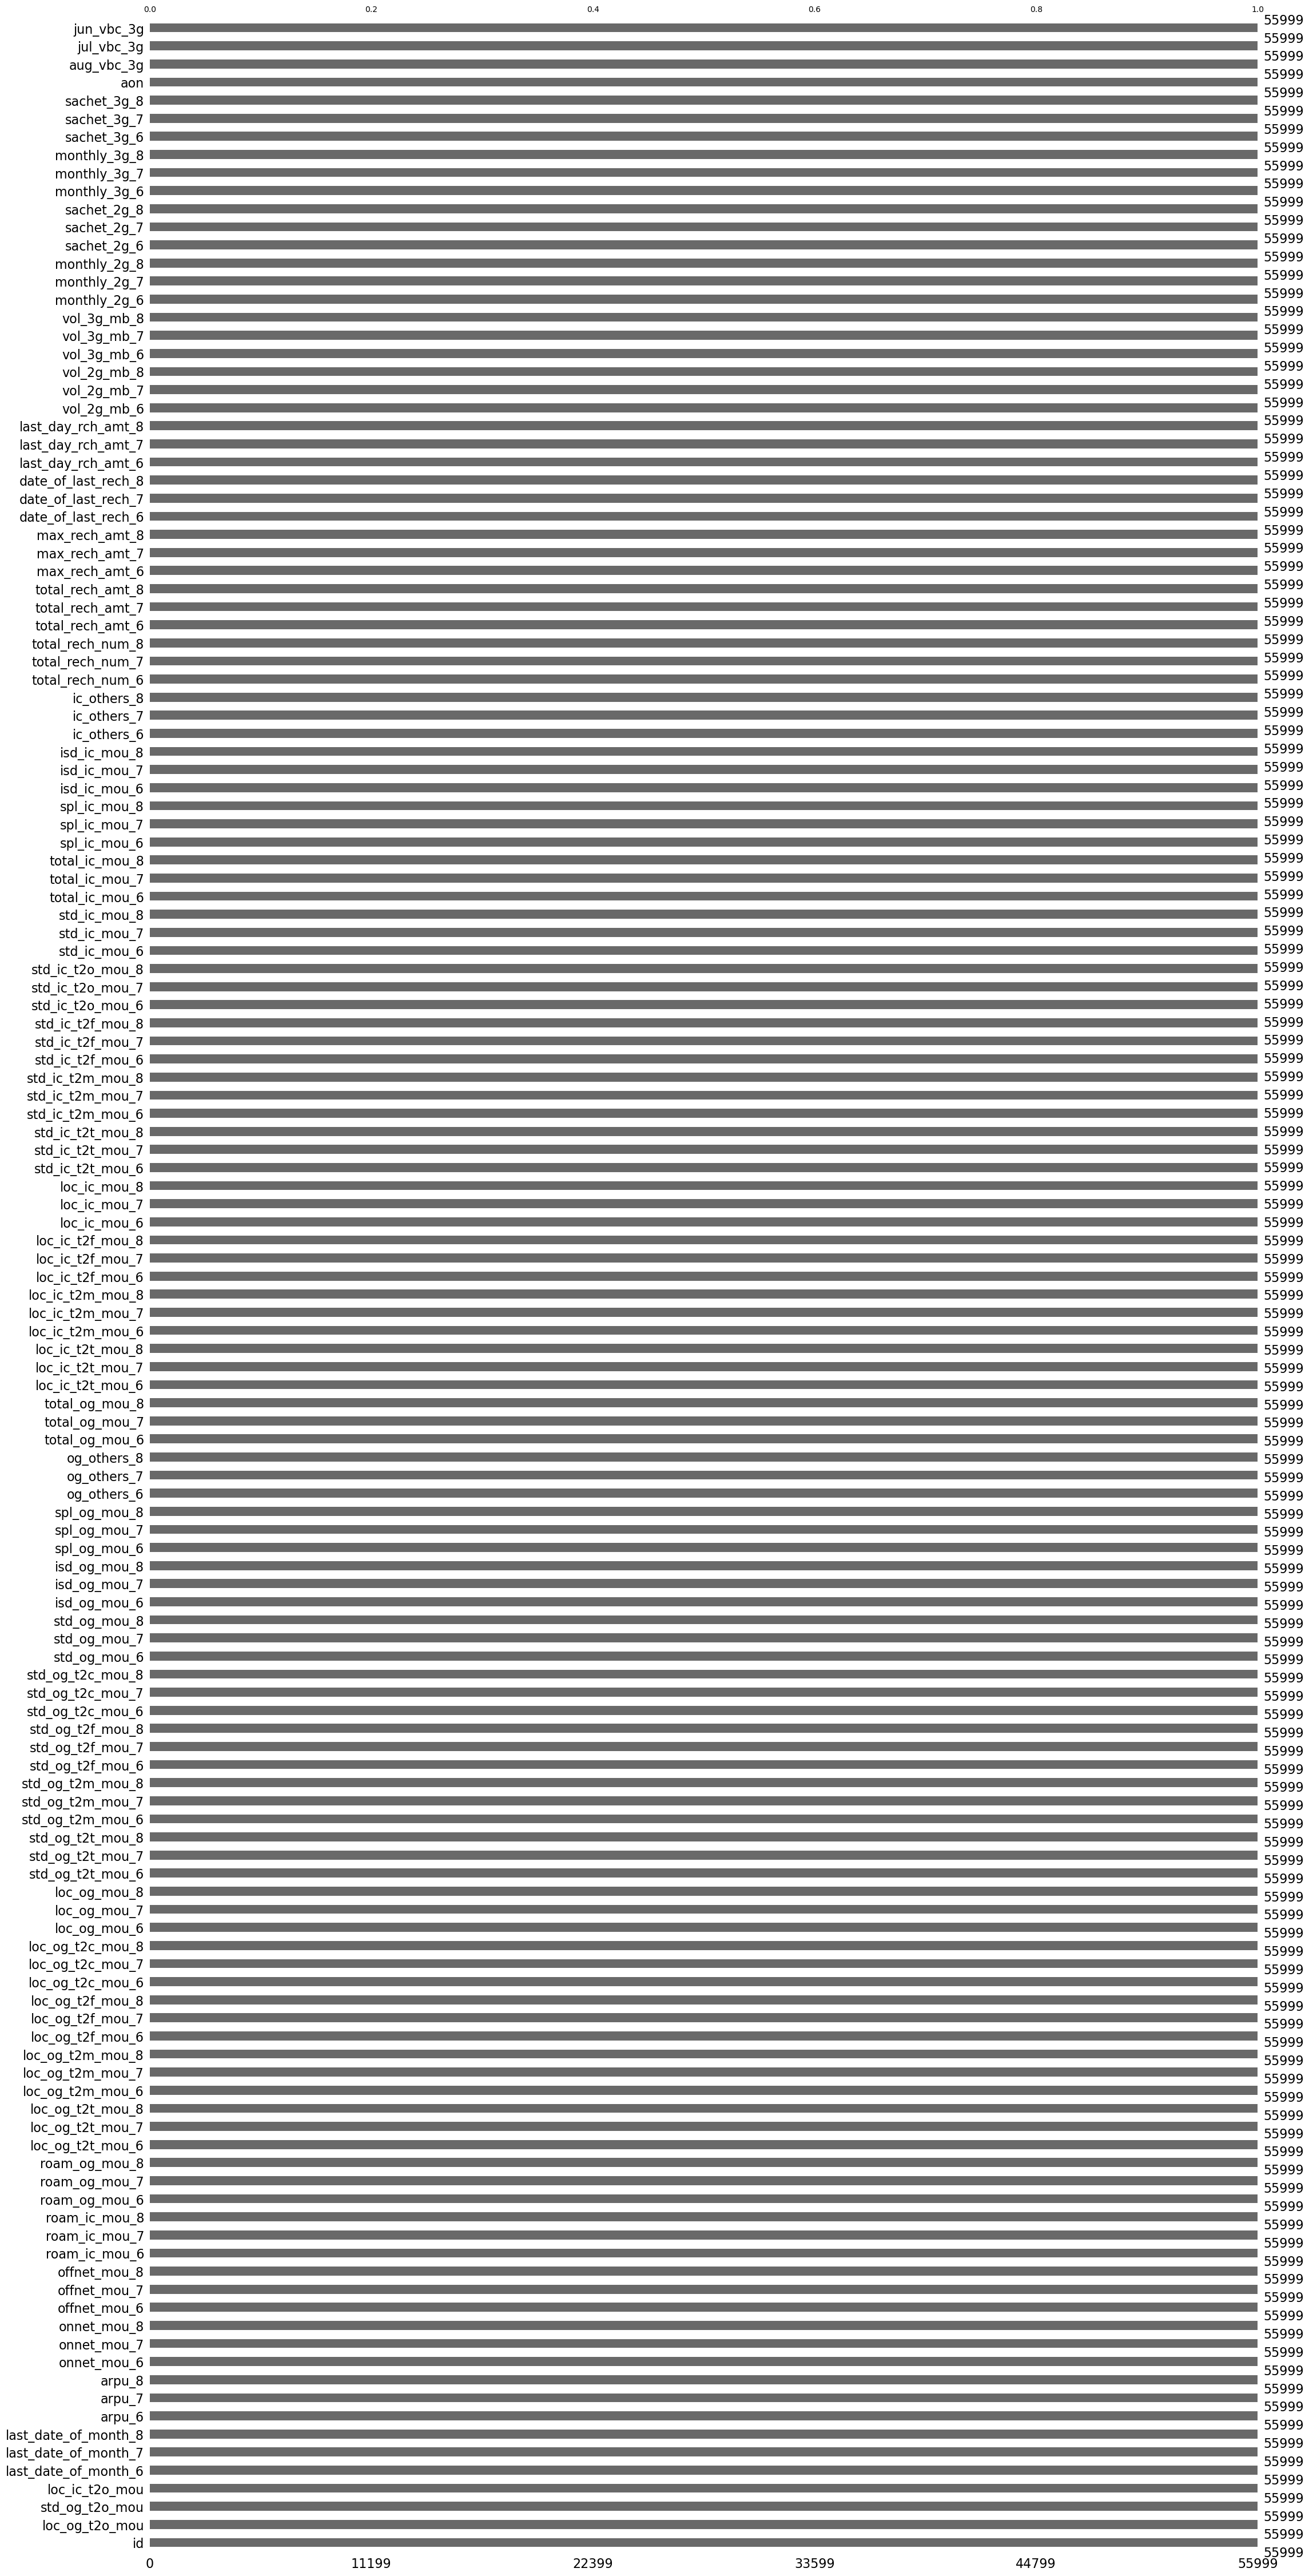

In [28]:
msno.bar(X_train_filtered)

In [29]:
X_train_filtered.describe()

id        arpu_6        arpu_7        arpu_8  total_og_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000    55999.000000   
mean   35046.215290    282.920597    278.555044    278.904174      305.812746   
std    20204.989439    339.882961    352.939330    351.091001      464.196869   
min        0.000000  -2041.228000  -1289.715000   -945.808000        0.000000   
25%    17540.500000     93.534000     86.816000     84.966500       44.360000   
50%    35092.000000    197.241000    192.408000    192.209000      145.130000   
75%    52562.000000    370.132000    365.145500    369.577500      372.610000   
max    69997.000000  27731.088000  35145.834000  33543.624000     8488.360000   

       total_og_mou_7  total_og_mou_8  total_ic_mou_6  total_ic_mou_7  \
count    55999.000000    55999.000000    55999.000000    55999.000000   
mean       309.531575      303.484753      199.442668      201.547161   
std        476.475332      472.308241      288.557329      294.783157   
min          0.000000        0.000000        0.000000        0.000000   
25%         42.780000       38.780000       38.210000       41.260000   
50%        141.460000      138.660000      114.580000      116.190000   
75%        378.775000      369.530000      249.945000      248.390000   
max       8285.640000     8309.780000     6633.180000     9699.010000   

       total_ic_mou_8  ...  monthly_3g_6  monthly_3g_7  monthly_3g_8  \
count    55999.000000  ...  55999.000000  55999.000000  55999.000000   
mean       198.211964  ...      0.075394      0.078644      0.082359   
std        285.770175  ...      0.358268      0.387758      0.383789   
min          0.000000  ...      0.000000      0.000000      0.000000   
25%         38.340000  ...      0.000000      0.000000      0.000000   
50%        114.580000  ...      0.000000      0.000000      0.000000   
75%        248.725000  ...      0.000000      0.000000      0.000000   
max       6476.360000  ...      9.000000     16.000000     16.000000   

        sachet_3g_6   sachet_3g_7   sachet_3g_8           aon    aug_vbc_3g  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean       0.073608      0.078144      0.083180   1222.525581     68.960181   
std        0.554031      0.601022      0.661754    954.550540    268.884652   
min        0.000000      0.000000      0.000000    180.000000      0.000000   
25%        0.000000      0.000000      0.000000    468.000000      0.000000   
50%        0.000000      0.000000      0.000000    869.000000      0.000000   
75%        0.000000      0.000000      0.000000   1815.500000      0.000000   
max       29.000000     33.000000     41.000000   4337.000000   8476.260000   

         jul_vbc_3g    jun_vbc_3g  
count  55999.000000  55999.000000  
mean      66.420389     59.941734  
std      268.348612    254.845989  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max     9165.600000  11166.210000  

[8 rows x 44 columns]

In [30]:
X_train_filtered.shape

(55999, 140)

In [31]:
X_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55999 entries, 3608 to 59120
Columns: 140 entries, id to jun_vbc_3g
dtypes: float64(18), int64(26), object(96)
memory usage: 60.2+ MB


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

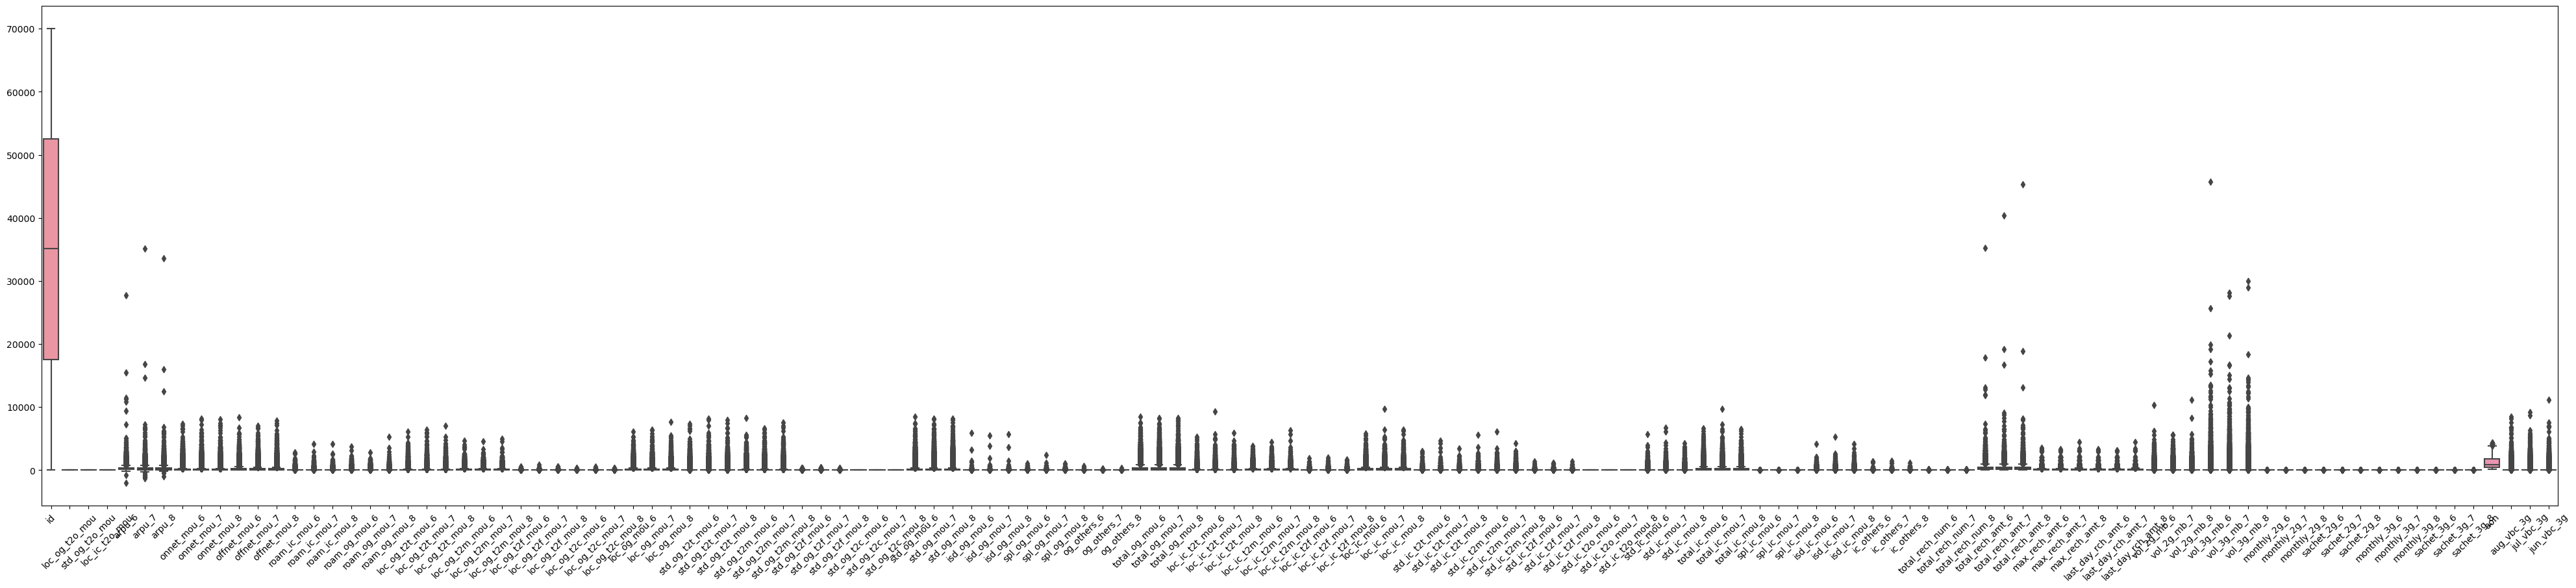

In [32]:
plt.figure(figsize=(50,10))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [33]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

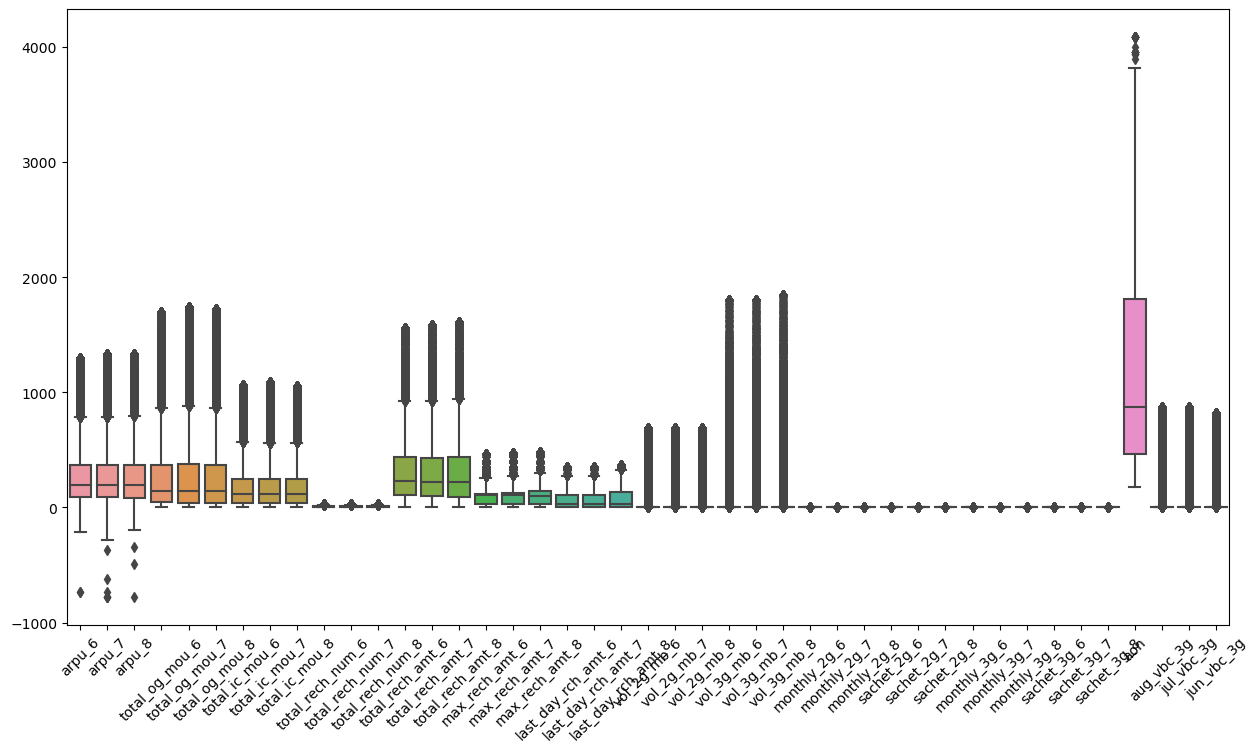

In [34]:
numeric_cols = X_train_filtered.select_dtypes(include=[np.number])

X_train_filtered1 = numeric_cols.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1.drop('id', axis=1))

In [35]:
X_train_filtered1.shape

(55999, 44)

In [36]:
X_train_filtered1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55999 entries, 3608 to 59120
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  55999 non-null  int64  
 1   arpu_6              55999 non-null  float64
 2   arpu_7              55999 non-null  float64
 3   arpu_8              55999 non-null  float64
 4   total_og_mou_6      55999 non-null  float64
 5   total_og_mou_7      55999 non-null  float64
 6   total_og_mou_8      55999 non-null  float64
 7   total_ic_mou_6      55999 non-null  float64
 8   total_ic_mou_7      55999 non-null  float64
 9   total_ic_mou_8      55999 non-null  float64
 10  total_rech_num_6    55999 non-null  float64
 11  total_rech_num_7    55999 non-null  float64
 12  total_rech_num_8    55999 non-null  float64
 13  total_rech_amt_6    55999 non-null  float64
 14  total_rech_amt_7    55999 non-null  float64
 15  total_rech_amt_8    55999 non-null  float64
 16  m

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [62]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1.drop('id', axis=1))

In [65]:
columnNames = X_train_filtered1.drop('id', axis=1).columns.tolist()

<Axes: >

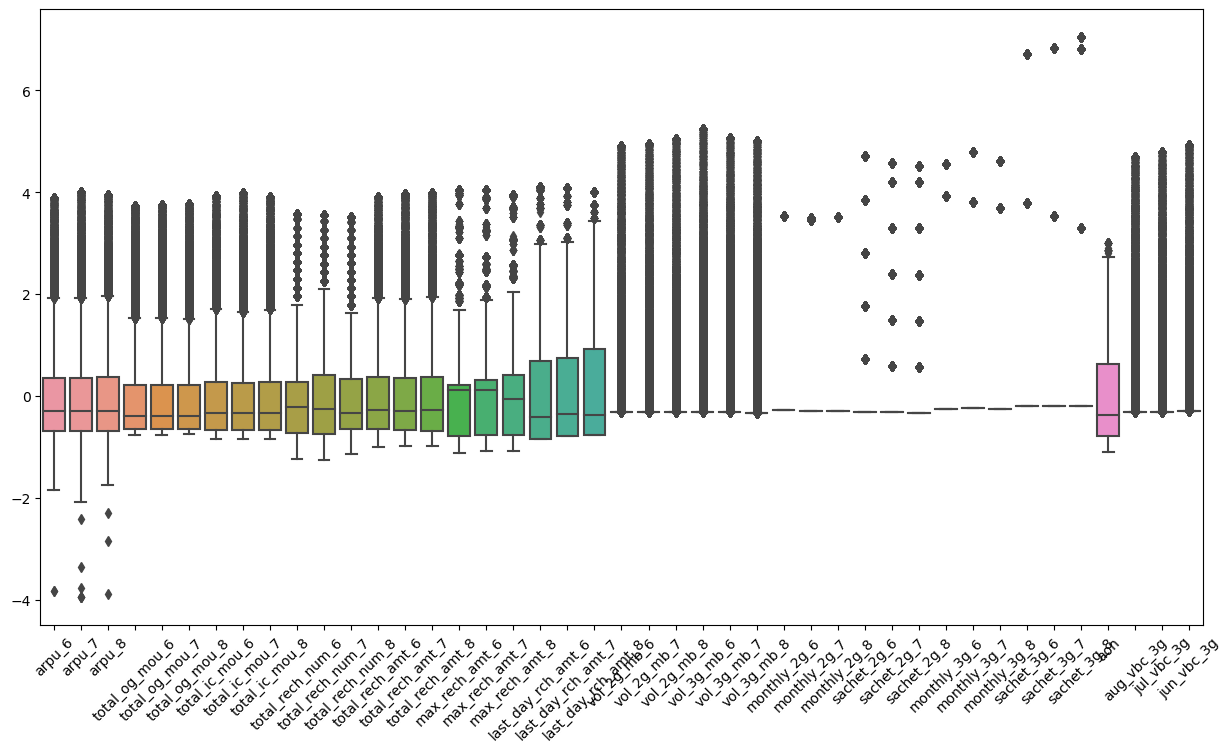

In [66]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=columnNames))

<Axes: >

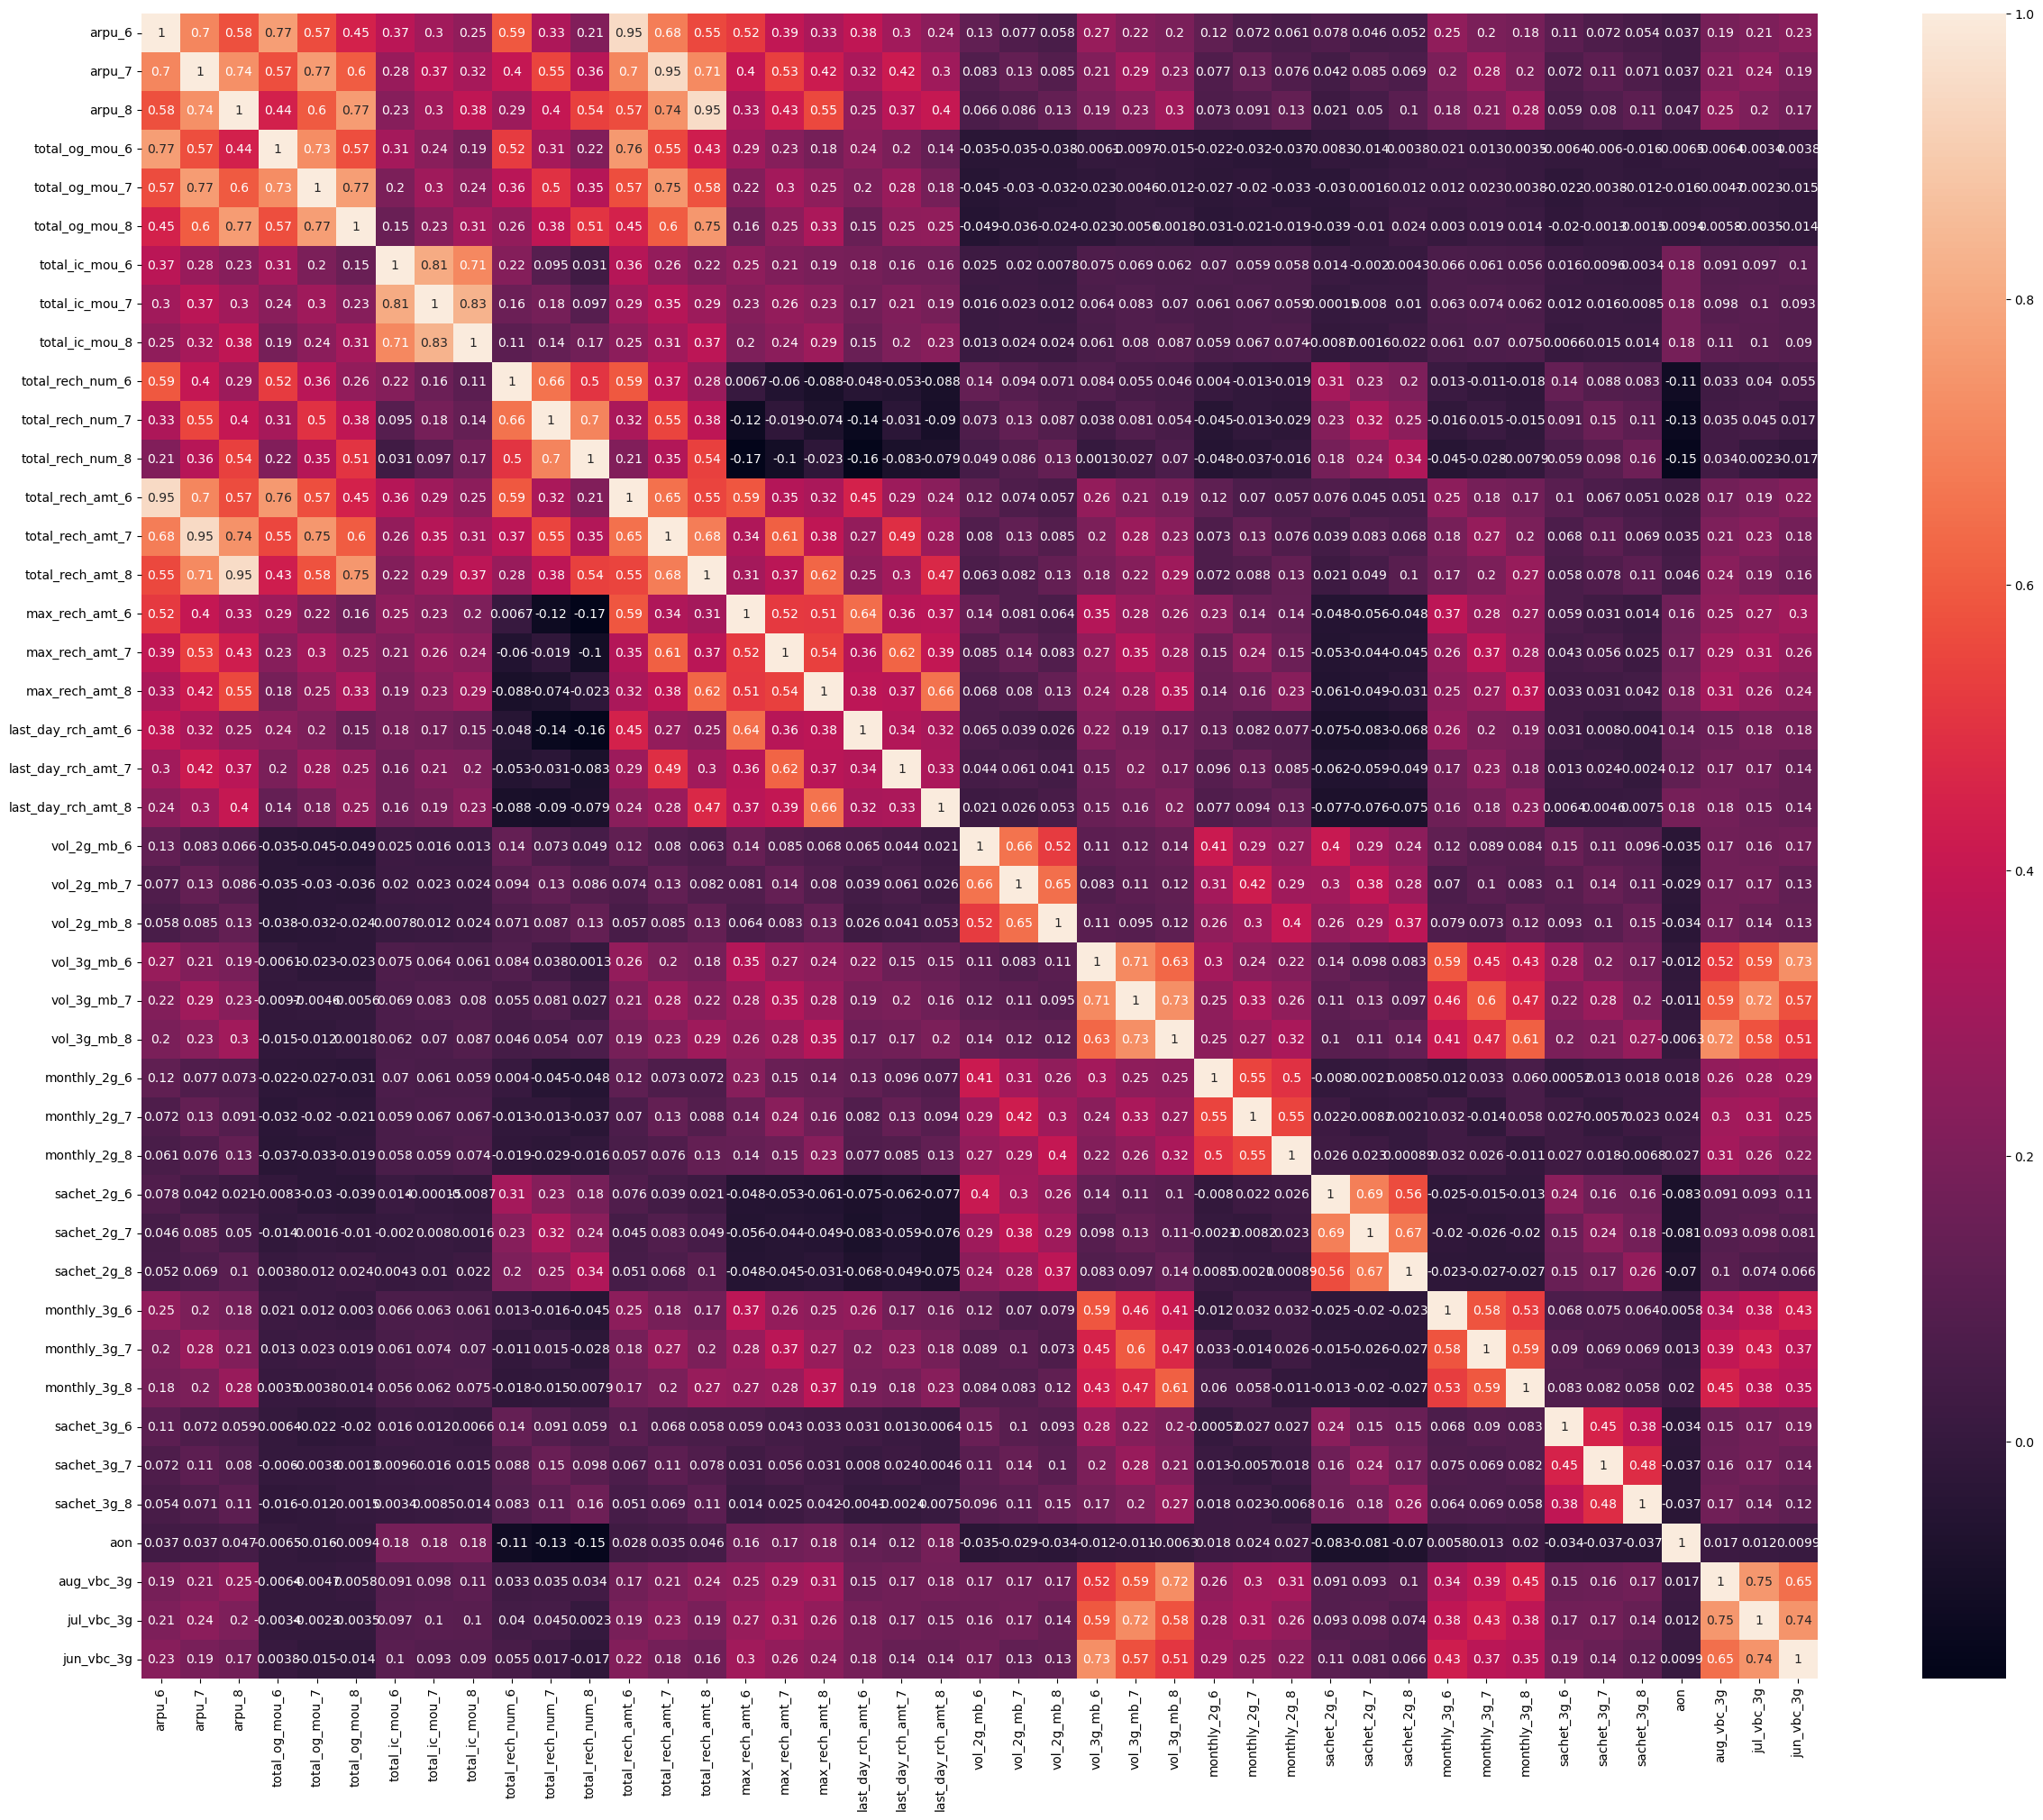

In [73]:
plt.figure(figsize=(30,24))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=columnNames).corr(), annot = True)

<Axes: xlabel='churn_probability', ylabel='Count'>

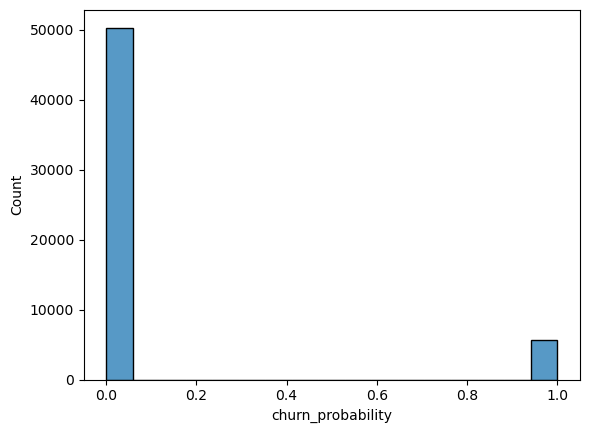

In [74]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [75]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [77]:
feature_importances = pd.DataFrame({'col':columnNames, 'importance':rf.feature_importances_})

<BarContainer object of 43 artists>

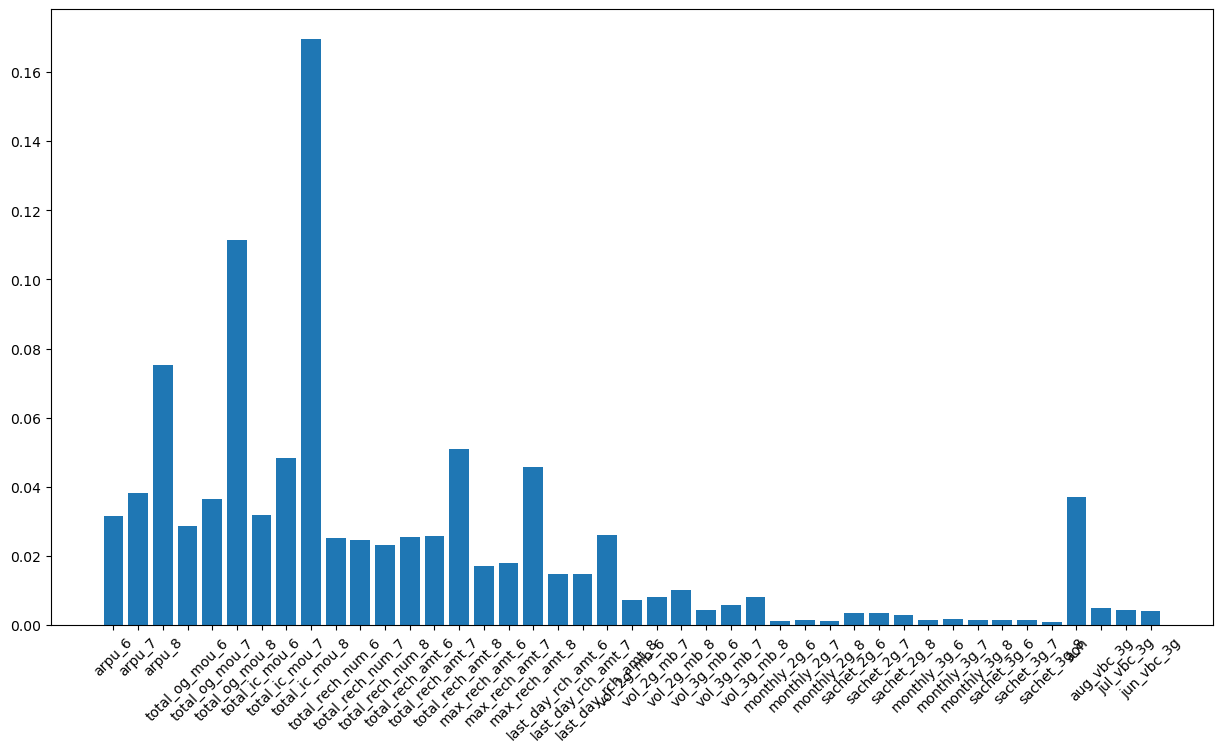

In [78]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

<Axes: >

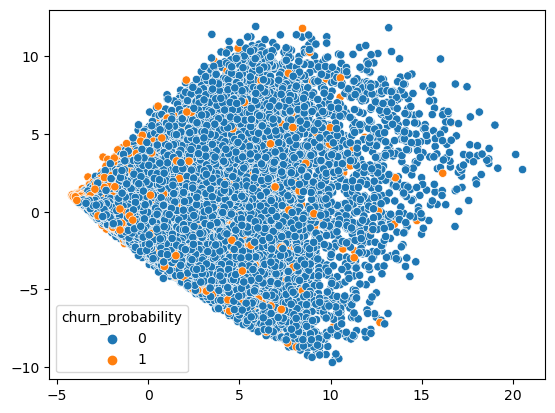

In [79]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

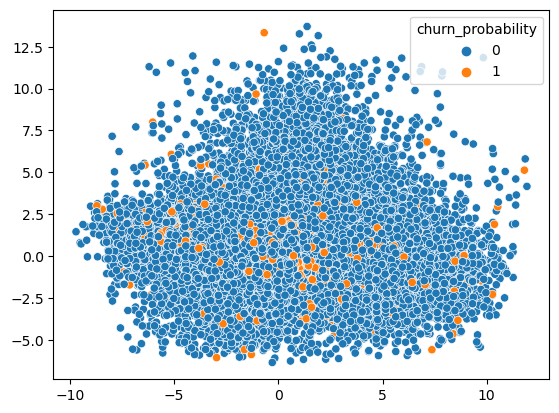

In [80]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

<BarContainer object of 43 artists>

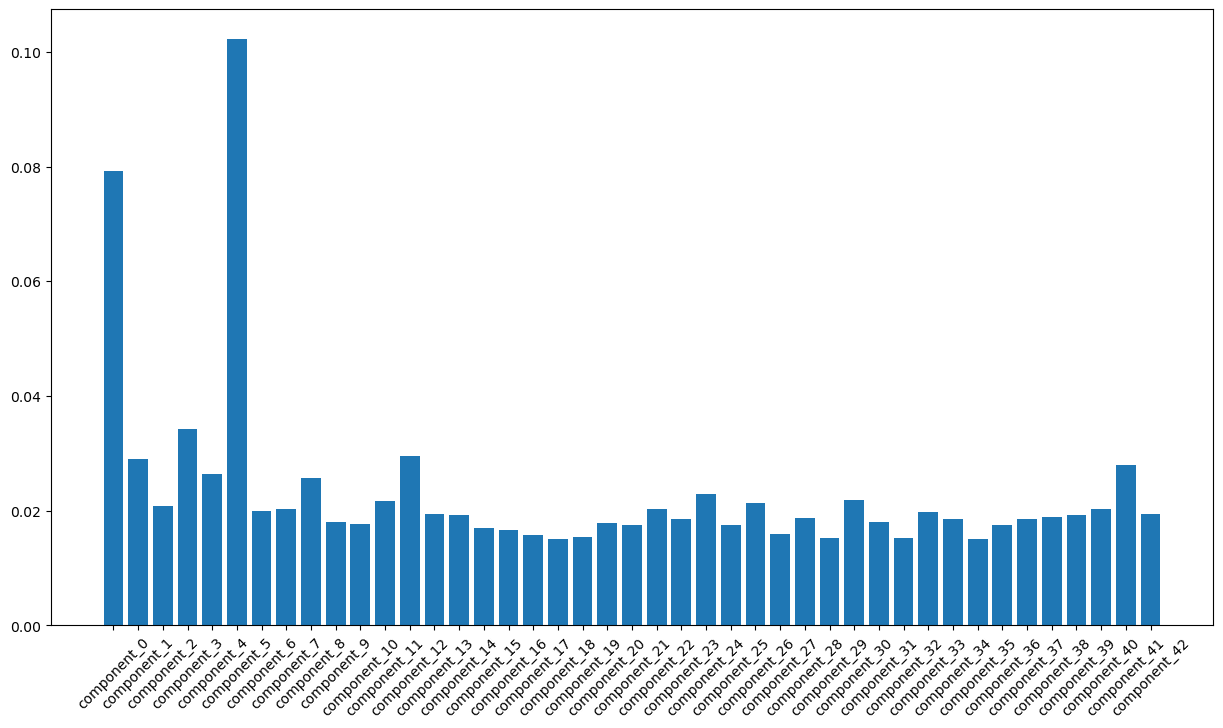

In [82]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(43)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [83]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [84]:
lr.score(pca_components[:,:2], y_train)

0.8984981874676333

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [85]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [86]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [88]:
pipe.fit(X_train[columnNames], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [90]:
train_score = pipe.score(X_train[columnNames], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9026946909766246


In [92]:
test_score = pipe.score(X_test[columnNames], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8987142857142857


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [93]:
confusion_matrix(y_train, pipe.predict(X_train[columnNames]))

array([[49944,   371],
       [ 5078,   606]])

In [94]:
confusion_matrix(y_test, pipe.predict(X_test[columnNames]))

array([[12428,   124],
       [ 1294,   154]])

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [95]:
precision_score(y_test, pipe.predict(X_test[columnNames]))

0.5539568345323741

In [96]:
recall_score(y_test, pipe.predict(X_test[columnNames]))

0.106353591160221

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [97]:
sample.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [98]:
unseen.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [99]:
submission_data = unseen.set_index('id')[columnNames]
submission_data.shape

(30000, 43)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [100]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  0
3  70002                  0
4  70003                  0

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [102]:
output.to_csv('submission_pca_lr_03Apr.csv',index=False)